# **Part 2: Pretrained CNNs**

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------

# Dataset

This takes the dataset and transforms it to fit the VGG19 data format.

Data > train/validation/test > label_1/label_2/.../label_102

One-time code to set up dataset.

Used on local machine.

In [ ]:
# import scipy.io
# import shutil
# import os

# # Load labels from imagelabels.mat
# data = scipy.io.loadmat('.../imagelabels.mat')
# labels = data['labels']

# # Directory paths
# source_dir = '.../jpg'  # Original dataset as given by the oxford 102 flowers site
# destination_dir = '.../dataset'  # Destination directory

# # Create folders for each label
# for label in set(labels.flatten()):
#     label_folder = os.path.join(destination_dir, f'label_{label}')
#     os.makedirs(label_folder, exist_ok=True)

# # Copy images to corresponding label folders
# for filename, label in zip(os.listdir(source_dir), labels.flatten()):
#     image_path = os.path.join(source_dir, filename)
#     label_folder = os.path.join(destination_dir, f'label_{label}')
#     shutil.copy(image_path, label_folder)

Ran once on drive to split dataset to train, test and validation.

Cannot split to both test and validation using built-in commands to get the specified 50% Train, 25% Validation and 25% Test sets.

In [ ]:
# import os
# import shutil
# import random

# data_dir = '/content/drive/MyDrive/dataset'
# train_dir = '/content/drive/MyDrive/DatasetVGG/train'
# valid_dir = '/content/drive/MyDrive/DatasetVGG/validation'
# test_dir = '/content/drive/MyDrive/DatasetVGG/test'

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(valid_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# for class_name in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, class_name)
#     if os.path.isdir(class_dir):
#         images = os.listdir(class_dir)
#         random.shuffle(images)

#         train_split = int(0.5 * len(images))
#         valid_split = int(0.75 * len(images))

#         train_images = images[:train_split]
#         valid_images = images[train_split:valid_split]
#         test_images = images[valid_split:]

#         for image in train_images:
#             src = os.path.join(class_dir, image)
#             dst = os.path.join(train_dir, class_name, image)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copyfile(src, dst)

#         for image in valid_images:
#             src = os.path.join(class_dir, image)
#             dst = os.path.join(valid_dir, class_name, image)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copyfile(src, dst)

#         for image in test_images:
#             src = os.path.join(class_dir, image)
#             dst = os.path.join(test_dir, class_name, image)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copyfile(src, dst)

In [ ]:
train_dir = '/content/drive/MyDrive/DatasetVGG/train'
valid_dir = '/content/drive/MyDrive/DatasetVGG/validation'
test_dir = '/content/drive/MyDrive/DatasetVGG/test'

------------------------------------------------------------

#VGG19

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

import tensorflow as tf
from keras.applications.vgg19 import preprocess_input
from keras.applications import VGG19

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical

Data loaders

In [ ]:
batch_size = 32
image_size = (224, 224)

# Use data augmentation for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# No augmentation on test and valid sets
valid_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4070 images belonging to 102 classes.
Found 2032 images belonging to 102 classes.
Found 2087 images belonging to 102 classes.


Model

In [ ]:
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze the Layers of VGG19. Tried unfreezing the last convolution block, but results were not adequate
# freeze_until_layer = "block5_conv1"
for layer in base_model_VGG19.layers:
    # if layer.name == freeze_until_layer:
    #     break
    layer.trainable = False

New linear classifier on top layer

In [ ]:
x = base_model_VGG19.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

In [ ]:
modelVGG19 = Model(inputs=base_model_VGG19.input, outputs=predictions)

In [ ]:
modelVGG19.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
modelVGG19.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // batch_size
valid_steps_per_epoch = valid_generator.samples // batch_size

# Train the model
epochs = 20
historyVGG19 = modelVGG19.fit(
                              train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=epochs,
                              validation_data=valid_generator,
                              validation_steps=valid_steps_per_epoch
)

Epoch 1/20
127/127 [==============================] - 99s 777ms/step - loss: 4.4472 - accuracy: 0.0527 - val_loss: 4.0476 - val_accuracy: 0.1166
Epoch 2/20
127/127 [==============================] - 97s 760ms/step - loss: 3.7101 - accuracy: 0.1449 - val_loss: 3.0743 - val_accuracy: 0.2619
Epoch 3/20
127/127 [==============================] - 94s 741ms/step - loss: 2.9671 - accuracy: 0.2623 - val_loss: 2.4573 - val_accuracy: 0.4013
Epoch 4/20
127/127 [==============================] - 94s 737ms/step - loss: 2.5011 - accuracy: 0.3517 - val_loss: 2.1713 - val_accuracy: 0.4221
Epoch 5/20
127/127 [==============================] - 95s 749ms/step - loss: 2.2140 - accuracy: 0.4066 - val_loss: 1.8424 - val_accuracy: 0.5169
Epoch 6/20
127/127 [==============================] - 96s 756ms/step - loss: 2.0073 - accuracy: 0.4527 - val_loss: 1.7023 - val_accuracy: 0.5446
Epoch 7/20
127/127 [==============================] - 95s 747ms/step - loss: 1.8759 - accuracy: 0.4921 - val_loss: 1.5897 - val_ac

In [ ]:
# Evaluate the model on the test data
test_steps = test_generator.samples // batch_size
score = modelVGG19.evaluate(test_generator, steps=test_steps)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

65/65 [==============================] - 18s 280ms/step - loss: 1.0281 - accuracy: 0.7231
Test loss: 1.0280715227127075
Test accuracy: 0.7230769395828247


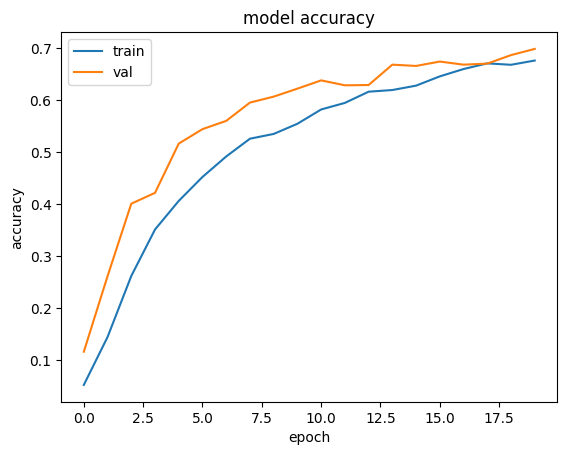

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historyVGG19.history['accuracy'])
plt.plot(historyVGG19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

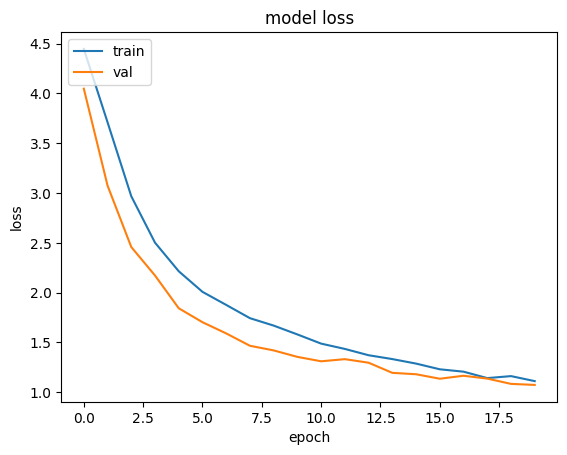

In [ ]:
plt.plot(historyVGG19.history['loss'])
plt.plot(historyVGG19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

--------------

# YOLOv5

Using YOLOv5s-cls : Classification Model

In [ ]:
import torch
import os
from IPython.display import Image, clear_output  # to display images

#clone YOLOv5 - one-time, as I need to transfer the dataset everytime. Takes long time on drive
# !git clone https://github.com/ultralytics/yolov5.git /content/drive/MyDrive/yolov5
%cd /content/drive/MyDrive/yolov5
%pip install -qr requirements.txt # install dependencies

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

/content/drive/MyDrive/yolov5
Setup complete. Using torch 2.0.1+cu118 (Tesla T4)


Using the same data format as the VGG19 model.

In [ ]:
# Classification model training using the Oxford 102 flowers dataset with the VGG19 data format (using the tutorial inside the repository under classify)
!python classify/train.py --img 224 --batch 32 --epochs 20 --data /content/drive/MyDrive/DatasetVGG --model yolov5s-cls.pt --cache

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/train: model=yolov5s-cls.pt, data=/content/drive/MyDrive/DatasetVGG, epochs=20, batch_size=32, imgsz=224, nosave=False, cache=ram, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.6 torch-2.0.1+cu

In [ ]:
# This is the TEST. In the YOLO files val.py refers to the TEST, as well as the directory it takes the data from.
!python classify/val.py --weights runs/train-cls/exp4/weights/best.pt --data /content/drive/MyDrive/DatasetVGG

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/val: data=/content/drive/MyDrive/DatasetVGG, weights=['runs/train-cls/exp4/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing: 100% 17/17 [00:12<00:00,  1.31it/s]
              

Evaluation plots

In [ ]:
import pandas as pd
histortYOLOv5 = pd.read_csv('runs/train-cls/exp4/results.csv')
histortYOLOv5.head()

,epoch,train/loss,test/loss,metrics/accuracy_top1,metrics/accuracy_top5,lr/0
0,0,2.6308,1.8091,0.73023,0.92669,0.000950
1,1,1.7225,1.4149,0.86440,0.97844,0.000901
2,2,1.5221,1.3626,0.86919,0.97556,0.000852
3,3,1.3781,1.2491,0.89938,0.98994,0.000802
4,4,1.2930,1.2151,0.91950,0.98802,0.000753


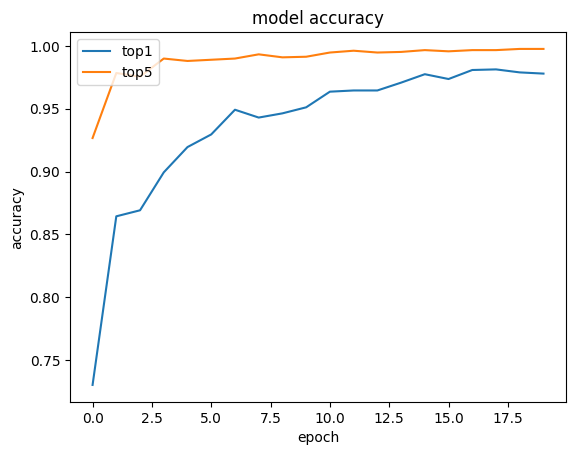

In [ ]:
import matplotlib.pyplot as plt

plt.plot(histortYOLOv5['                  epoch'],histortYOLOv5['  metrics/accuracy_top1'])
plt.plot(histortYOLOv5['                  epoch'],histortYOLOv5['  metrics/accuracy_top5'])
# plt.plot(historyVGG19.history['val_accuracy']) # Does YOLOv5 not record validation accuracy?
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['top1', 'top5'], loc='upper left')
plt.show()

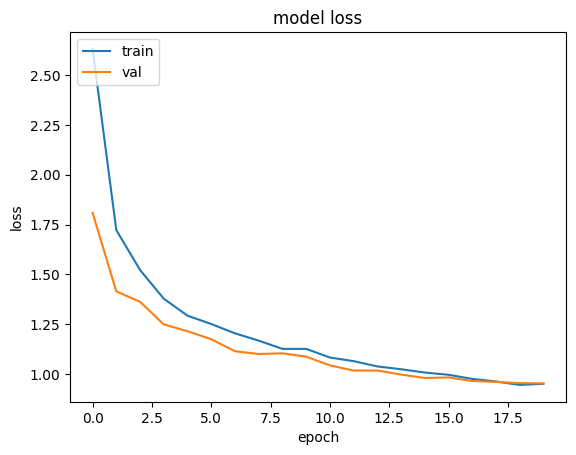

In [ ]:
plt.plot(histortYOLOv5['                  epoch'],histortYOLOv5['             train/loss'])
plt.plot(histortYOLOv5['                  epoch'],histortYOLOv5['              test/loss']) # named test in the YOLO files but it's the validation set
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()